#### This notebook supports the CMSE 890 Spring 2025 project titled “Enhancing Financial Decision Accuracy: A Machine Learning Approach to Loan Approvals.” To run the notebook, start by importing the libraries in the next cell.

Author: Diego Piraquive Gomez

In [487]:
import numpy as np
import pandas as pd
import kagglehub

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [85]:
path = kagglehub.dataset_download("architsharma01/loan-approval-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/diegopiraquive/.cache/kagglehub/datasets/architsharma01/loan-approval-prediction-dataset/versions/1


In [91]:
files = os.listdir(path)
print(files)

['loan_approval_dataset.csv']


In [95]:
loan = pd.read_csv(f"{path}/loan_approval_dataset.csv")
loan

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,4265,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000,Rejected
4265,4266,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000,Approved
4266,4267,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000,Rejected
4267,4268,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,14100000,5800000,Approved


### Initial Data Analysis

In [105]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


We see an unnecessary blank space in front of the column names, except `loan_id`. Let's fix this:

In [124]:
loan.columns = loan.columns.str.replace(' ', '')
loan.columns

Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')

In [126]:
loan.describe()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2135.000000,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1232.498479,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1068.000000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2135.000000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,3202.000000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


In [128]:
loan.duplicated().sum()

0

#### IDA Observations:

- There are a total of 4269 rows and 13 columns in the dataset.
- There are not missing values nor duplicates.
- `education` and `self_employed` are categorical variable, which might need encoding. The rest of the features are numericals.
- Column names were refined by deleting extra blank space.
- No major data cleaning steps are requiered.

### Exploratory Data Analysis

In [442]:
loan_eda = loan.drop(['loan_id'], axis=1)

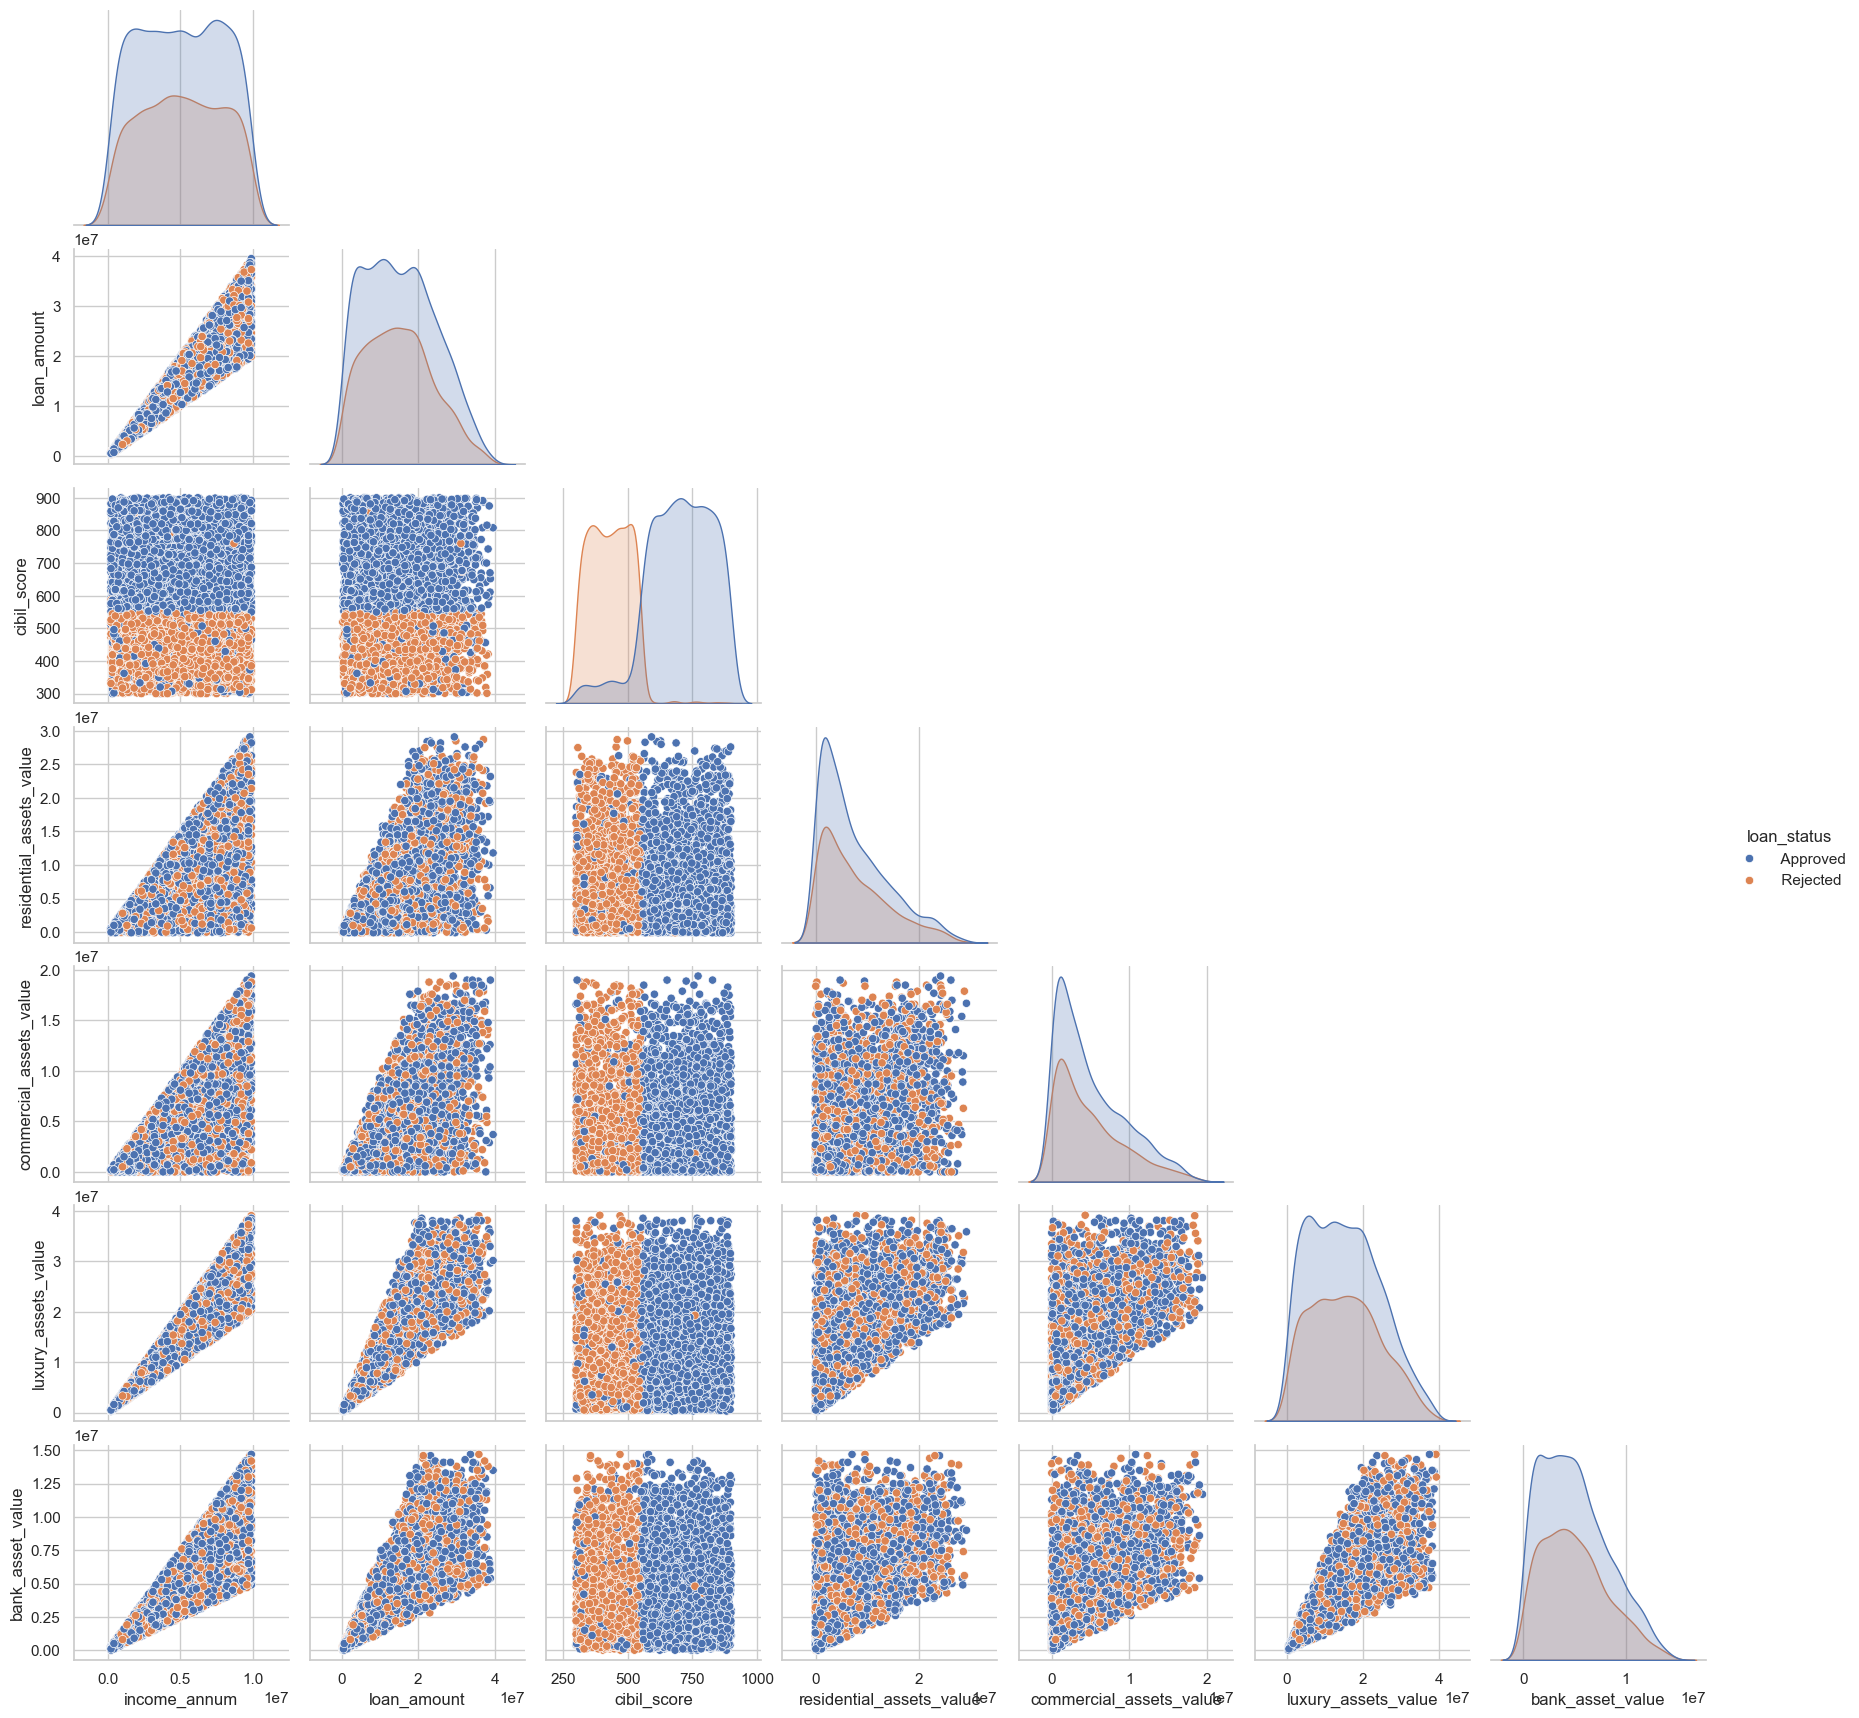

In [454]:
sns.pairplot(
    loan_eda.drop(columns=['no_of_dependents', 'loan_term']),
    hue='loan_status',
    corner=True
)

We observe that certain variables show a positive correlation. For instance, `loan_amount` and `income_annum`, `luxury_assets_value` and `bank_asset_value`, as well as `income_annum` and `luxury_assets_value`. This provides a good starting point for further exploration.

Let’s explore one of the most important variables, `loan_amount`, and its relationship with the target variable.

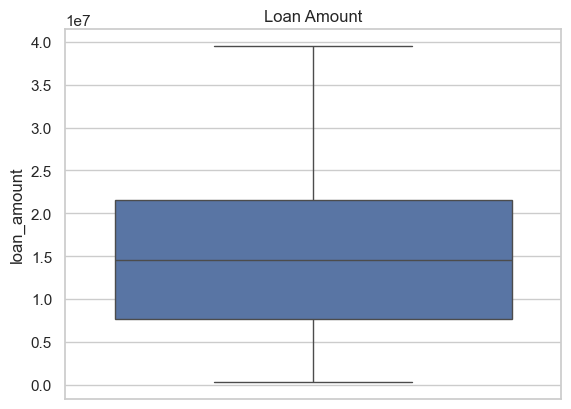

In [163]:
sns.boxplot(loan_eda['loan_amount'])
plt.title("Loan Amount")
plt.show()

The box plot shows that loan_amount has a wide range, but no clear outliers are visible.

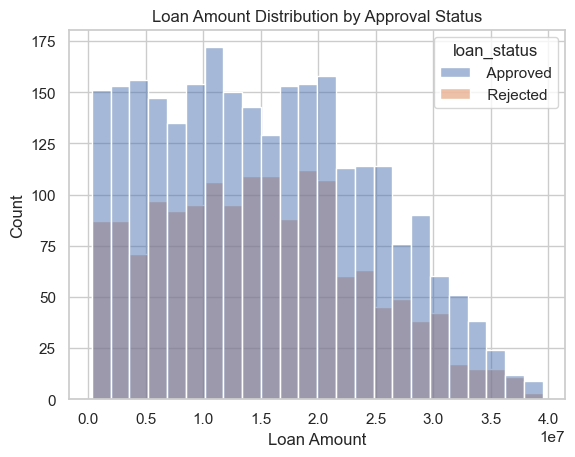

In [167]:
sns.histplot(loan_eda, x='loan_amount', hue='loan_status')
plt.title("Loan Amount Distribution by Approval Status")
plt.xlabel("Loan Amount")
plt.ylabel("Count")
plt.show()

Loan approvals and rejections appear evenly distributed across loan amounts, indicating no strong relationship between these features. Does more income mean higher loan amounts and a higher approval rate? Let’s explore it:

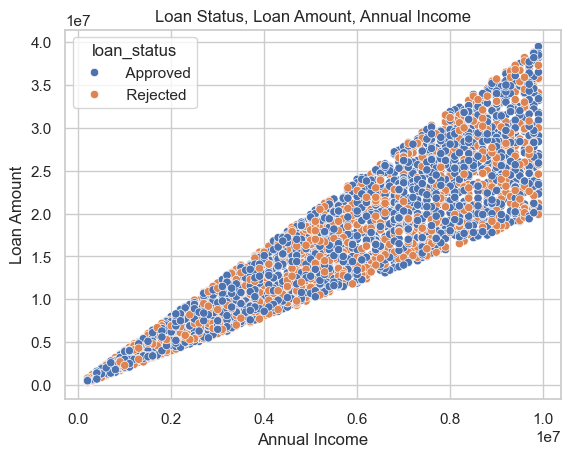

In [458]:
sns.scatterplot(x=loan_eda['income_annum'], y= loan_eda['loan_amount'], hue=loan_eda['loan_status'])
plt.title("Loan Status, Loan Amount, Annual Income")
plt.xlabel("Annual Income")
plt.ylabel("Loan Amount")
plt.show()

Some insight about the above figure:
- As income goes up, people tend to request bigger loans.
- However, income alone doesn’t clearly affect whether a loan is approved or not.
- People with low income usually apply for smaller loans, while those with high income ask for a wider range of loan amounts.
- Lenders likely match loan amounts to income to make sure borrowers can pay them back.
- Interestingly, even the highest earners sometimes get rejected for smaller loans. This might depend on the lender or other factors. Let’s take a closer look at these applicants to better understand the situation:

In [177]:
loan_eda.loc[(loan_eda['income_annum'] == loan_eda['income_annum'].max()) & (loan_eda['loan_status'] ==' Rejected')]

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
82,2,Not Graduate,Yes,9900000,21200000,16,363,25500000,11400000,26600000,6800000,Rejected
157,5,Not Graduate,Yes,9900000,33300000,6,364,5300000,18700000,27800000,8300000,Rejected
1179,5,Graduate,No,9900000,35700000,10,392,7900000,4300000,39200000,13000000,Rejected
1272,5,Not Graduate,No,9900000,35800000,20,470,9500000,18400000,39100000,14700000,Rejected
1409,3,Graduate,Yes,9900000,29900000,20,490,10500000,9100000,27100000,7400000,Rejected
1547,1,Graduate,Yes,9900000,34100000,14,371,24400000,7100000,29300000,6200000,Rejected
1890,5,Graduate,No,9900000,24600000,2,530,24200000,12800000,20400000,13000000,Rejected
2862,4,Graduate,No,9900000,30000000,18,496,10400000,8000000,29300000,13800000,Rejected
2869,4,Graduate,No,9900000,26100000,2,481,14500000,5000000,23600000,9300000,Rejected
3000,1,Not Graduate,Yes,9900000,25700000,2,340,15600000,18800000,29500000,11800000,Rejected


We can observe that one thing these applicants have in common is a ‘poor’ credit score (`cibil_score`). According to Experian, credit scores are categorized as follows: 300–579: Poor, 580–669: Fair, 670–739: Good, 740–799: Very Good, and 800–850: Exceptional.

Source: https://www.experian.com/blogs/ask-experian/credit-education/score-basics/what-is-a-good-credit-score/#:~:text=Quick%20Answer,above%20is%20generally%20considered%20good.

As we observed in the pairplot, there is a clear separation in loan status around the 540–550 credit score range, indicating a strong correlation between credit score and loan status. However, a good credit score by itself is not a guarantee of loan approval, as shown in the plot above—highlighting the complexity of the decision-making process. Let’s take a closer look at these applicants to see if we can get an idea of this situation:

In [191]:
loan_eda.loc[(loan_eda['cibil_score'] > 740) & (loan_eda['loan_status'] ==' Rejected')].sort_values(['cibil_score'], ascending= False)

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
559,2,Graduate,Yes,200000,500000,6,885,-100000,0,300000,200000,Rejected
3527,0,Graduate,No,1800000,6900000,10,853,900000,400000,3700000,1700000,Rejected
911,0,Graduate,Yes,1300000,4800000,4,835,500000,100000,3300000,800000,Rejected
3213,1,Not Graduate,Yes,4300000,16300000,14,792,400000,400000,10200000,4000000,Rejected
236,3,Graduate,Yes,900000,3500000,4,770,700000,0,2000000,600000,Rejected
4099,3,Graduate,No,8700000,31100000,16,760,400000,1800000,19300000,4800000,Rejected
1446,1,Graduate,No,300000,1200000,18,747,100000,0,700000,200000,Rejected


We have several applicants with credit scores above 740 whose loan applications were rejected. Before moving on to the correlation matrix, let’s take a look at the distribution of asset values in the dataset and their relationship with loan status:

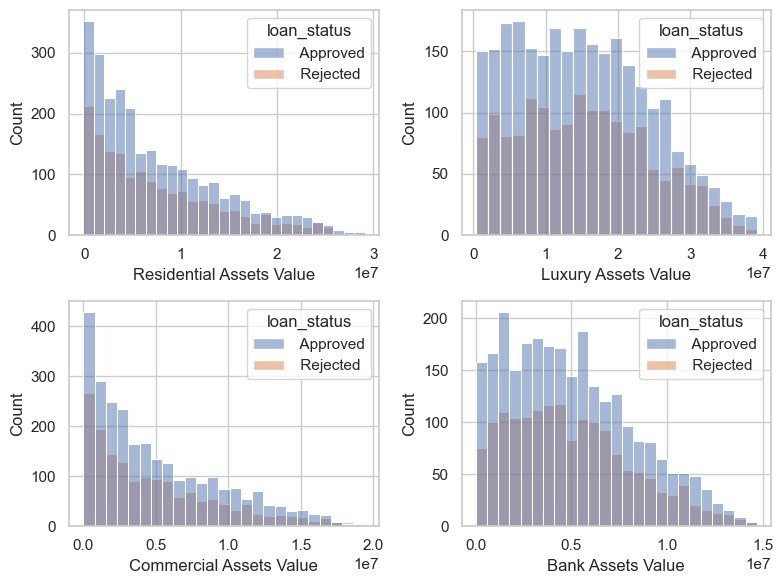

In [196]:
fig,axes = plt.subplots(2, 2, figsize = (8, 6))

sns.histplot(loan_eda, x = 'residential_assets_value', hue = 'loan_status', ax = axes[0,0])
axes[0,0].set_xlabel("Residential Assets Value")
axes[0,0].set_ylabel("Count")

sns.histplot(loan_eda, x = 'commercial_assets_value', hue = 'loan_status', ax = axes[1,0])
axes[1,0].set_xlabel("Commercial Assets Value")
axes[1,0].set_ylabel("Count")

sns.histplot(loan_eda, x = 'luxury_assets_value', hue = 'loan_status', ax = axes[0,1])
axes[0,1].set_xlabel("Luxury Assets Value")
axes[0,1].set_ylabel("Count")

sns.histplot(loan_eda, x = 'bank_asset_value', hue = 'loan_status', ax = axes[1,1])
axes[1,1].set_xlabel("Bank Assets Value")
axes[1,1].set_ylabel("Count")

plt.tight_layout()
plt.show()

We observe that applicants with higher asset values slighly tend to have more loan approvals. Let's move forward with the correlation matrix, but first, let's enconde the categorical variables:

In [432]:
loan_eda['education'] = loan_eda['education'].astype(str).str.strip()
loan_eda['self_employed'] = loan_eda['self_employed'].astype(str).str.strip()
loan_eda['loan_status'] = loan_eda['loan_status'].astype(str).str.strip()

loan_eda['education'] = loan_eda['education'].map({'Not Graduate': 0, 'Graduate': 1})
loan_eda['self_employed'] = loan_eda['self_employed'].map({'No': 0, 'Yes': 1})
loan_eda['loan_status'] = loan_eda['loan_status'].map({'Rejected': 0, 'Approved': 1})

loan_eda.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


Now, the encoding for these variables is:

| Variable      | Value          | Encoding |
|---------------|----------------|----------|
| loan_status   | Approved       | 1        |
|               | Rejected       | 0        |
| education     | Graduate       | 1        |
|               | Not Graduate   | 0        |
| self_employed | Yes            | 1        |
|               | No             | 0        |

Checking that all the variables have the correct format:

In [ ]:
loan_eda.dtypes

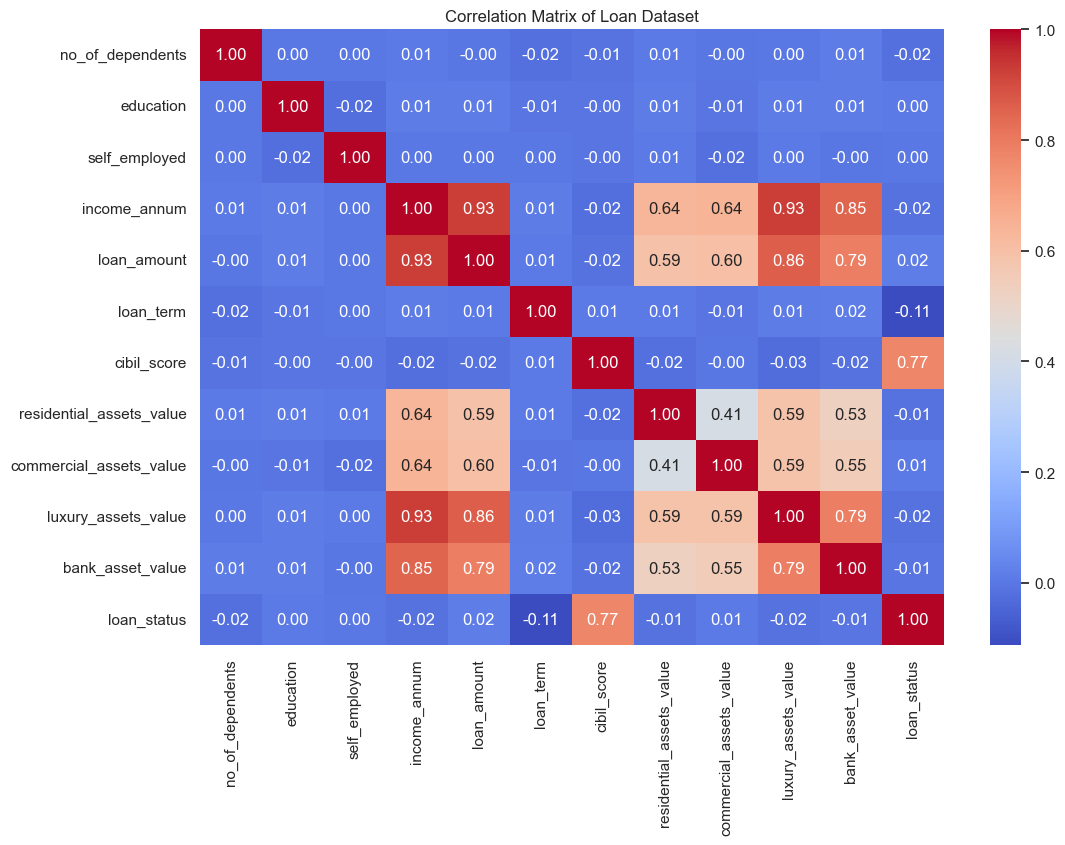

In [281]:
loan_eda_corr = loan_eda.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(loan_eda_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Loan Dataset")
plt.show()

Key insights from the correlation matrix:

- People with higher incomes usually ask for bigger loans. This is shown by a strong link between income and loan amount.
- People with more valuable assets like luxury items or bank savings tend to apply for larger loans.
- Bigger loans often have longer payback times, but this connection isn’t very strong.
- People with higher credit scores are more likely to get their loans approved. This is one of the strongest links we see.
- Surprisingly, having more money or assets doesn’t guarantee that someone will get their loan approved.
- Whether someone is self-employed or their education level doesn’t really affect whether they get a loan.

Now, let's take a look of possible outliers:

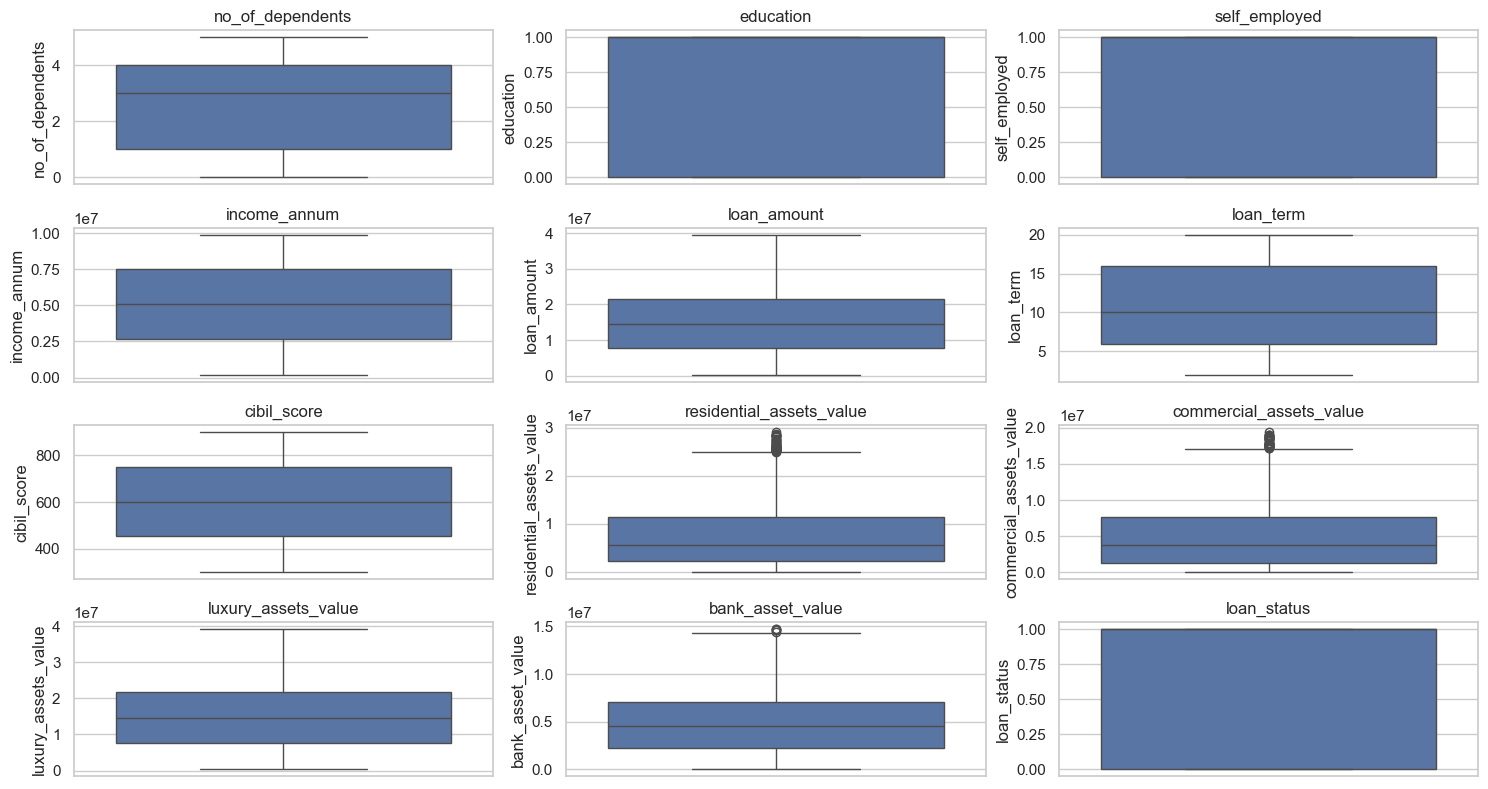

In [288]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(loan_eda.columns):
    plt.subplot(len(loan_eda.columns) // 3 + 1, 3, i + 1)
    sns.boxplot(y=loan_eda[col])
    plt.title(col)
plt.tight_layout()
plt.show()

We identified some outliers in `residential_assets_value`, `commercial_assets_value`, and `bank_asset_value`. To address this, we will use StandardScaler during the preprocessing stage, which reduces the influence of these outliers by scaling data based on the median and interquartile range.

### Data Preparation

**Principal Component Analysis (PCA)**

We decided not to use PCA because it would reduce the interpretability of the features. Understanding the direct influence of specific financial variables like income, assets, and credit score on loan approval is crucial; PCA’s transformation would obscure these clear relationships, making it harder to interpret the results.

**Class Balance**

In [312]:
print("\nClass Distribution Percentage:\n", (loan_eda['loan_status'].value_counts()) / len(loan_eda) * 100)


Class Distribution Percentage:
 loan_status
1    62.215976
0    37.784024
Name: count, dtype: float64


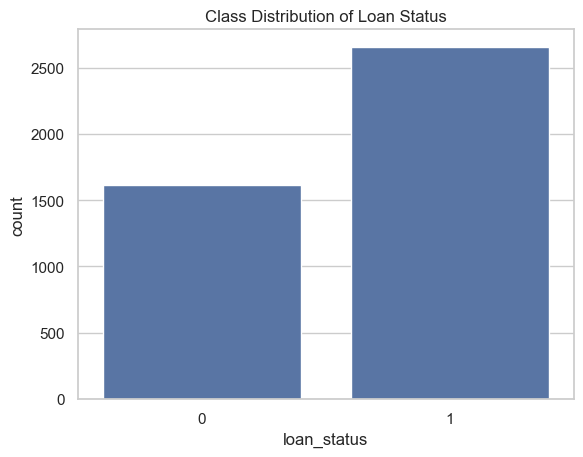

In [304]:
sns.countplot(x=loan_eda['loan_status'])
plt.title('Class Distribution of Loan Status')
plt.show()

We found a moderate class imbalance in the target variable, with about 62% approved and 38% rejected loans. To understand the impact of this imbalance, we will set up two pipelines: one using the original data, and another applying SMOTE to balance the classes. Both pipelines will include data splitting and model comparison across several classification algorithms. 

In [394]:
# Define the models
models = {
    "Decision Tree": (DecisionTreeClassifier(), {'classifier__max_depth': [None, 10, 20, 30]}),
    "Random Forest": (RandomForestClassifier(), {'classifier__n_estimators': [100, 200]}),
    "Logistic Regression": (LogisticRegression(), {'classifier__C': [0.1, 1, 10]}),
    "SVM": (SVC(probability=True), {'classifier__C': [1, 10, 100]}),
    "k-NN": (KNeighborsClassifier(), {'classifier__n_neighbors': [3, 5, 7]}),
    "Naive Bayes": (GaussianNB(), {}),
    "Gradient Boosting": (GradientBoostingClassifier(), {'classifier__n_estimators': [100, 200]}),
    "XGBoost": (XGBClassifier(), {'classifier__n_estimators': [100, 200]})
}

# Split the data
X = loan_eda.drop('loan_status', axis=1)
y = loan_eda['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate and print the evaluation metrics for the test set
def evaluate_model(name, model, X_test, y_test, best_params):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    if hasattr(model, "predict_proba"): 
        proba_positive_class = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, proba_positive_class)
        print(f"{name} - Test Set Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc:.4f}")
    else:
        print(f"{name} - Test Set Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("AUC-ROC: Not available - predict_proba not supported")

    print("Best Parameters:", best_params)
    print("-" * 40)

feature_importances = {}

for name, (model, grid) in models.items():
    print(f"Evaluating {name} without SMOTE...")
    grid_search = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('classifier', model)]), 
                              grid, cv=5, scoring='accuracy')
    best_model = grid_search.fit(X_train, y_train).best_estimator_
    best_params = grid_search.best_params_
    print("Training Metrics:")
    evaluate_model(name, best_model, X_train, y_train, best_params)  # Evaluate on training data
    print("Testing Metrics:")
    evaluate_model(name, best_model, X_test, y_test, best_params)  # Evaluate on testing data
    
    print(f"Evaluating {name} with SMOTE...")
    grid_search_smote = GridSearchCV(ImbPipeline([('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()), ('classifier', model)]), 
                                    grid, cv=5, scoring='accuracy')
    best_model_smote = grid_search_smote.fit(X_train, y_train).best_estimator_
    best_params_smote = grid_search_smote.best_params_
    print("Training Metrics with SMOTE:")
    evaluate_model(name + " with SMOTE", best_model_smote, X_train, y_train, best_params_smote)  # Evaluate on training data
    print("Testing Metrics with SMOTE:")
    evaluate_model(name + " with SMOTE", best_model_smote, X_test, y_test, best_params_smote)  # Evaluate on testing data

# Now, extract and print feature importances
print("\nFeature Importances:")
for name, (model, _) in models.items():
    if 'feature_importances_' in dir(model):
        # Accessing the feature importances from the best model
        if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
            importances = best_model.named_steps['classifier'].feature_importances_
            feature_importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values(by='importance', ascending=False)
            feature_importances[name] = feature_importances_df
            print(f"{name} Feature Importances:\n{feature_importances_df}\n")

Evaluating Decision Tree without SMOTE...
Training Metrics:
Decision Tree - Test Set Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000
Best Parameters: {'classifier__max_depth': None}
----------------------------------------
Testing Metrics:
Decision Tree - Test Set Performance:
Accuracy: 0.9742
Precision: 0.9724
Recall: 0.9724
F1-Score: 0.9724
AUC-ROC: 0.9724
Best Parameters: {'classifier__max_depth': None}
----------------------------------------
Evaluating Decision Tree with SMOTE...
Training Metrics with SMOTE:
Decision Tree with SMOTE - Test Set Performance:
Accuracy: 0.9947
Precision: 0.9958
Recall: 0.9931
F1-Score: 0.9944
AUC-ROC: 0.9999
Best Parameters: {'classifier__max_depth': 10}
----------------------------------------
Testing Metrics with SMOTE:
Decision Tree with SMOTE - Test Set Performance:
Accuracy: 0.9754
Precision: 0.9752
Recall: 0.9721
F1-Score: 0.9736
AUC-ROC: 0.9795
Best Parameters: {'classifier__max_depth': 10}
------

The initial test set evaluations display promising results, especially for tree-based models such as Gradient Boosting and XGBoost, which exhibit high accuracy and AUC scores. To ensure these results are not a product of **overfitting** and to confirm the models’ ability to generalize across different data subsets, we will now implement **cross-validation.**

In [372]:
# Cross-validation for each model without SMOTE
cv_scores = {}
for name, (model, _) in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    cv_scores[name] = scores
    print(f"{name} CV Accuracy Scores: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Cross-validation for each model with SMOTE
cv_scores_smote = {}
for name, (model, _) in models.items():
    pipeline_smote = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline_smote, X, y, cv=5, scoring='accuracy')
    cv_scores_smote[name] = scores
    print(f"{name} with SMOTE CV Accuracy Scores: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Decision Tree CV Accuracy Scores: 0.9754 (+/- 0.0095)
Random Forest CV Accuracy Scores: 0.9836 (+/- 0.0051)
Logistic Regression CV Accuracy Scores: 0.9175 (+/- 0.0139)
SVM CV Accuracy Scores: 0.9389 (+/- 0.0150)
k-NN CV Accuracy Scores: 0.8962 (+/- 0.0192)
Naive Bayes CV Accuracy Scores: 0.9328 (+/- 0.0143)
Gradient Boosting CV Accuracy Scores: 0.9801 (+/- 0.0072)
XGBoost CV Accuracy Scores: 0.9843 (+/- 0.0048)
Decision Tree with SMOTE CV Accuracy Scores: 0.9806 (+/- 0.0060)
Random Forest with SMOTE CV Accuracy Scores: 0.9792 (+/- 0.0045)
Logistic Regression with SMOTE CV Accuracy Scores: 0.9197 (+/- 0.0155)
SVM with SMOTE CV Accuracy Scores: 0.9379 (+/- 0.0178)
k-NN with SMOTE CV Accuracy Scores: 0.8946 (+/- 0.0169)
Naive Bayes with SMOTE CV Accuracy Scores: 0.9414 (+/- 0.0109)
Gradient Boosting with SMOTE CV Accuracy Scores: 0.9813 (+/- 0.0026)
XGBoost with SMOTE CV Accuracy Scores: 0.9824 (+/- 0.0026)


### Conclusions

- Tree-based models like Gradient Boosting and XGBoost show excellent accuracy, precision, recall, and AUC-ROC scores, indicating they are well-suited for predicting loan status. They perform robustly both with and without SMOTE.
- The low variability in cross-validation scores suggests these models generalize well across different subsets of data.
- Models like k-NN and Logistic Regression show lower scores, indicating less suitability for this specific dataset or needing more complex feature engineering or hyperparameter tuning.
- cibil_score and loan_term are the most important features influencing predictions. This suggests credit history and loan duration are critical in assessing loan default risks.
- The high AUC-ROC values indicate a strong ability of the models to distinguish between classes (default vs. non-default), which is crucial for reliable financial decision-making.
- SMOTE generally maintains or slightly improves model performance, particularly for minority classes, enhancing model fairness and reducing bias in predictions.

Real-World Applications:
- The best-performing models (Gradient Boosting or XGBoost) can be implemented in a production environment to assist financial institutions in predicting loan default likelihood. This could be integrated into loan approval software.
- Additionally, can provide insights into loan applications, helping loan officers make informed decisions quickly.
- Set up a system to retrain models on new data periodically to adapt to changes in loan behavior patterns and economic factors. For this we might need new variables regarding the consistency on payments or external financial rates.



### Appendix

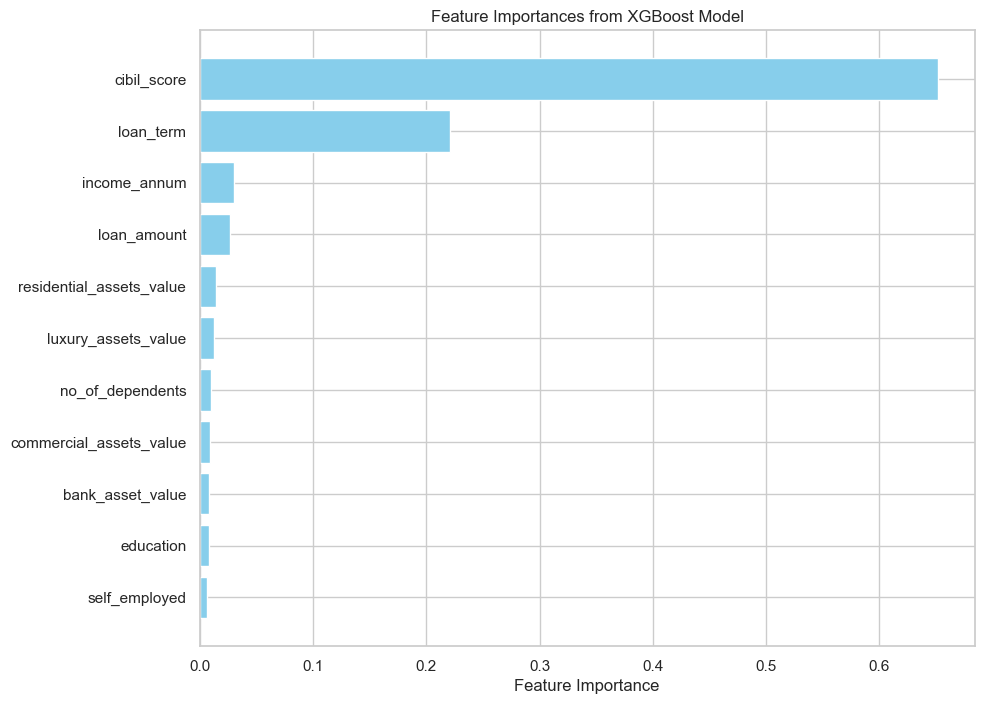

In [387]:
if 'XGBoost' in feature_importances:
    df_importances = feature_importances['XGBoost']
    df_importances = df_importances.sort_values('importance', ascending=True)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(df_importances['feature'], df_importances['importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title('Feature Importances from XGBoost Model')
    plt.show()
else:
    print("XGBoost feature importances are not available.")

### Model Evaluation Results

| Model          | SMOTE Applied | Metric    | Training | Testing | Best Parameters             |
|----------------|---------------|-----------|----------|---------|-----------------------------|
| Decision Tree  | No            | Accuracy  | 1.0000   | 0.9742  | `max_depth: None`          |
| Decision Tree  | No            | Precision | 1.0000   | 0.9724  | `max_depth: None`          |
| Decision Tree  | No            | Recall    | 1.0000   | 0.9724  | `max_depth: None`          |
| Decision Tree  | No            | F1-Score  | 1.0000   | 0.9724  | `max_depth: None`          |
| Decision Tree  | No            | AUC-ROC   | 1.0000   | 0.9724  | `max_depth: None`          |
| Decision Tree  | Yes           | Accuracy  | 0.9947   | 0.9754  | `max_depth: 10`            |
| Decision Tree  | Yes           | Precision | 0.9958   | 0.9752  | `max_depth: 10`            |
| Decision Tree  | Yes           | Recall    | 0.9931   | 0.9721  | `max_depth: 10`            |
| Decision Tree  | Yes           | F1-Score  | 0.9944   | 0.9736  | `max_depth: 10`            |
| Decision Tree  | Yes           | AUC-ROC   | 0.9999   | 0.9795  | `max_depth: 10`            |
| Random Forest     | No            | Accuracy  | 1.0000   | 0.9778  | `n_estimators: 100`           |
| Random Forest     | No            | Precision | 1.0000   | 0.9777  | `n_estimators: 100`           |
| Random Forest     | No            | Recall    | 1.0000   | 0.9746  | `n_estimators: 100`           |
| Random Forest     | No            | F1-Score  | 1.0000   | 0.9761  | `n_estimators: 100`           |
| Random Forest     | No            | AUC-ROC   | 1.0000   | 0.9980  | `n_estimators: 100`           |
| Random Forest     | Yes           | Accuracy  | 1.0000   | 0.9754  | `n_estimators: 200`           |
| Random Forest     | Yes           | Precision | 1.0000   | 0.9740  | `n_estimators: 200`           |
| Random Forest     | Yes           | Recall    | 1.0000   | 0.9734  | `n_estimators: 200`           |
| Random Forest     | Yes           | F1-Score  | 1.0000   | 0.9737  | `n_estimators: 200`           |
| Random Forest     | Yes           | AUC-ROC   | 1.0000   | 0.9979  | `n_estimators: 200`           |
| Gradient Boosting | No            | Accuracy  | 0.9994   | 0.9801  | `n_estimators: 200`           |
| Gradient Boosting | No            | Precision | 0.9995   | 0.9796  | `n_estimators: 200`           |
| Gradient Boosting | No            | Recall    | 0.9992   | 0.9777  | `n_estimators: 200`           |
| Gradient Boosting | No            | F1-Score  | 0.9994   | 0.9787  | `n_estimators: 200`           |
| Gradient Boosting | No            | AUC-ROC   | 1.0000   | 0.9980  | `n_estimators: 200`           |
| Gradient Boosting | Yes           | Accuracy  | 0.9997   | 0.9778  | `n_estimators: 200`           |
| Gradient Boosting | Yes           | Precision | 0.9998   | 0.9771  | `n_estimators: 200`           |
| Gradient Boosting | Yes           | Recall    | 0.9996   | 0.9752  | `n_estimators: 200`           |
| Gradient Boosting | Yes           | F1-Score  | 0.9997   | 0.9762  | `n_estimators: 200`           |
| Gradient Boosting | Yes           | AUC-ROC   | 1.0000   | 0.9978  | `n_estimators: 200`           |


| Model              | SMOTE Applied | Metric    | Training | Testing | Best Parameters                |
|--------------------|---------------|-----------|----------|---------|--------------------------------|
| Logistic Regression| No            | Accuracy  | 0.9183   | 0.9098  | `C: 0.1`                      |
| Logistic Regression| No            | Precision | 0.9134   | 0.9046  | `C: 0.1`                      |
| Logistic Regression| No            | Recall    | 0.9130   | 0.9020  | `C: 0.1`                      |
| Logistic Regression| No            | F1-Score  | 0.9132   | 0.9032  | `C: 0.1`                      |
| Logistic Regression| No            | AUC-ROC   | 0.9686   | 0.9677  | `C: 0.1`                      |
| Logistic Regression| Yes           | Accuracy  | 0.9253   | 0.9110  | `C: 0.1`                      |
| Logistic Regression| Yes           | Precision | 0.9173   | 0.9014  | `C: 0.1`                      |
| Logistic Regression| Yes           | Recall    | 0.9277   | 0.9131  | `C: 0.1`                      |
| Logistic Regression| Yes           | F1-Score  | 0.9217   | 0.9063  | `C: 0.1`                      |
| Logistic Regression| Yes           | AUC-ROC   | 0.9679   | 0.9676  | `C: 0.1`                      |
| SVM                | No            | Accuracy  | 0.9786   | 0.9403  | `C: 10`                       |
| SVM                | No            | Precision | 0.9771   | 0.9354  | `C: 10`                       |
| SVM                | No            | Recall    | 0.9775   | 0.9371  | `C: 10`                       |
| SVM                | No            | F1-Score  | 0.9773   | 0.9362  | `C: 10`                       |
| SVM                | No            | AUC-ROC   | 0.9959   | 0.9870  | `C: 10`                       |
| SVM                | Yes           | Accuracy  | 0.9777   | 0.9379  | `C: 10`                       |
| SVM                | Yes           | Precision | 0.9752   | 0.9310  | `C: 10`                       |
| SVM                | Yes           | Recall    | 0.9777   | 0.9378  | `C: 10`                       |
| SVM                | Yes           | F1-Score  | 0.9764   | 0.9341  | `C: 10`                       |
| SVM                | Yes           | AUC-ROC   | 0.9961   | 0.9870  | `C: 10`                       |

| Model              | SMOTE Applied | Metric    | Training | Testing | Best Parameters                |
|--------------------|---------------|-----------|----------|---------|--------------------------------|
| k-NN               | No            | Accuracy  | 0.9283   | 0.9005  | `n_neighbors: 7`              |
| k-NN               | No            | Precision | 0.9229   | 0.8916  | `n_neighbors: 7`              |
| k-NN               | No            | Recall    | 0.9252   | 0.8977  | `n_neighbors: 7`              |
| k-NN               | No            | F1-Score  | 0.9240   | 0.8944  | `n_neighbors: 7`              |
| k-NN               | No            | AUC-ROC   | 0.9814   | 0.9627  | `n_neighbors: 7`              |
| k-NN               | Yes           | Accuracy  | 0.9493   | 0.8911  | `n_neighbors: 3`              |
| k-NN               | Yes           | Precision | 0.9424   | 0.8805  | `n_neighbors: 3`              |
| k-NN               | Yes           | Recall    | 0.9527   | 0.8973  | `n_neighbors: 3`              |
| k-NN               | Yes           | F1-Score  | 0.9469   | 0.8863  | `n_neighbors: 3`              |
| k-NN               | Yes           | AUC-ROC   | 0.9913   | 0.9430  | `n_neighbors: 3`              |
| Naive Bayes        | No            | Accuracy  | 0.9353   | 0.9368  | {}                            |
| Naive Bayes        | No            | Precision | 0.9295   | 0.9296  | {}                            |
| Naive Bayes        | No            | Recall    | 0.9341   | 0.9368  | {}                            |
| Naive Bayes        | No            | F1-Score  | 0.9316   | 0.9329  | {}                            |
| Naive Bayes        | No            | AUC-ROC   | 0.9666   | 0.9703  | {}                            |
| Naive Bayes        | Yes           | Accuracy  | 0.9414   | 0.9403  | {}                            |
| Naive Bayes        | Yes           | Precision | 0.9336   | 0.9315  | {}                            |
| Naive Bayes        | Yes           | Recall    | 0.9462   | 0.9454  | {}                            |
| Naive Bayes        | Yes           | F1-Score  | 0.9388   | 0.9372  | {}                            |
| Naive Bayes        | Yes           | AUC-ROC   | 0.9669   | 0.9711  | {}                            |

| Model              | SMOTE Applied | Metric    | Training | Testing | Best Parameters                |
|--------------------|---------------|-----------|----------|---------|--------------------------------|
| XGBoost            | No            | Accuracy  | 1.0000   | 0.9824  | `n_estimators: 100`          |
| XGBoost            | No            | Precision | 1.0000   | 0.9821  | `n_estimators: 100`          |
| XGBoost            | No            | Recall    | 1.0000   | 0.9803  | `n_estimators: 100`          |
| XGBoost            | No            | F1-Score  | 1.0000   | 0.9812  | `n_estimators: 100`          |
| XGBoost            | No            | AUC-ROC   | 1.0000   | 0.9981  | `n_estimators: 100`          |
| XGBoost            | Yes           | Accuracy  | 1.0000   | 0.9848  | `n_estimators: 100`          |
| XGBoost            | Yes           | Precision | 1.0000   | 0.9840  | `n_estimators: 100`          |
| XGBoost            | Yes           | Recall    | 1.0000   | 0.9834  | `n_estimators: 100`          |
| XGBoost            | Yes           | F1-Score  | 1.0000   | 0.9837  | `n_estimators: 100`          |
| XGBoost            | Yes           | AUC-ROC   | 1.0000   | 0.9979  | `n_estimators: 100`          |
